

# Выбор локации для скважины



Компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой Bootstrap.

**Шаги для выбора локации:**

В избранном регионе ищут месторождения, для каждого определяют значения признаков;

Строят модель и оценивают объём запасов;

Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;

Прибыль равна суммарной прибыли отобранных месторождений.


**Содержание**

1) Загрузка и подготовка данных

2) Обучение и проверка модели

3)  Подготовка к расчёту прибыли

4)  Расчёт прибыли и рисков

5) Оценка рисков и прибыли для каждого региона


**Описание данных** 

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**

1) Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

2) При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

3) Бюджет на разработку скважин в регионе — 10 млрд рублей.

4) При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

5) После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

6) Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных


In [37]:
#импортируем нужные библиотеки для работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error




### Поработаем с датасетом 0

In [38]:
#прочитаем данные 'C:/Users/Lerusik/Documents/datasets/geo_data_0.csv' (для себя)
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


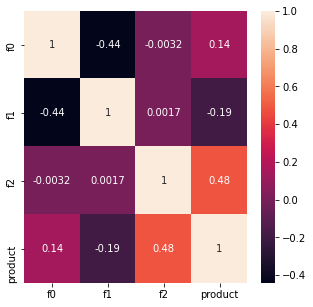

In [39]:
#посмотрим матрицу корреляций
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(ax=ax, data=data_0.corr(), annot = True)
plt.show()

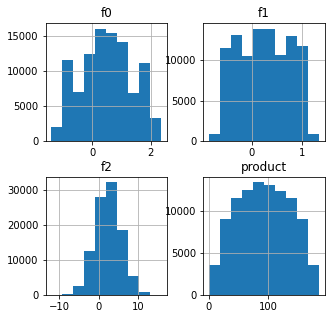

In [40]:
#получим гистограммы по всем столбцам
data_0.hist(figsize=(5, 5))
plt.show()

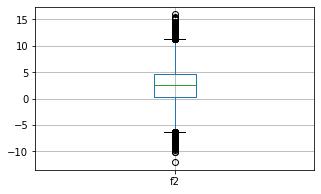

In [41]:
#проверим на выбросы
data_0.boxplot('f2', figsize=(5, 3))
plt.show()

In [42]:
#получим общую информацию о датасете
data_0.info()
print('Пропусков нет, ура')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Пропусков нет, ура


In [43]:
#удалим столбец с индексом, он будет мешать логистической регрессии
data_0.drop(columns=data_0.columns[0], axis= 1 , inplace= True )
data_0

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...
99995,0.971957,0.370953,6.075346,110.744026
99996,1.392429,-0.382606,1.273912,122.346843
99997,1.029585,0.018787,-1.348308,64.375443
99998,0.998163,-0.528582,1.583869,74.040764


In [44]:
#кодировать нам тут ничего не нужно, но стандартизировать и разделить данные - да
features_0 = data_0.drop(['product'],axis=1)
target_0 = data_0['product'] #целевой признак

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)



pd.options.mode.chained_assignment = None #чтобы не появлялось предупреждение SettingWithCopy

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_0[numeric])
features_train_0[numeric] = scaler.transform(features_train_0[numeric])
features_valid_0[numeric] = scaler.transform(features_valid_0[numeric])







### Поработаем с датасетом 1

In [45]:
#прочитаем данные C:/Users/Lerusik/Documents/datasets/geo_data_1.csv
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


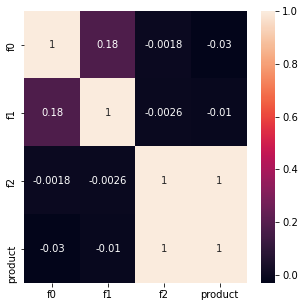

In [46]:
#посмотрим матрицу корреляций
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(ax=ax, data=data_1.corr(), annot = True)
plt.show()

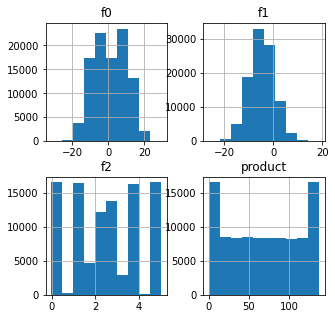

In [47]:
#получим гистограммы по всем столбцам
data_1.hist(figsize=(5, 5))
plt.show()

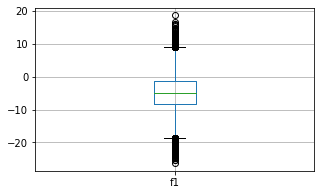

In [48]:
#проверим на выбросы
data_1.boxplot('f1', figsize=(5, 3))
plt.show()

In [49]:
#получим общую информацию о датасете
data_1.info()
print('Пропусков нет, ура')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Пропусков нет, ура


In [50]:
#удалим столбец с индексом, он будет мешать логистической регрессии
data_1.drop(columns=data_1.columns[0], axis= 1 , inplace= True )

In [51]:
#кодировать нам тут ничего не нужно, но стандартизировать и разделить данные - да
features_1 = data_1.drop(['product'],axis=1)
target_1 = data_1['product'] #целевой признак

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)



pd.options.mode.chained_assignment = None #чтобы не появлялось предупреждение SettingWithCopy

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_1[numeric])
features_train_1[numeric] = scaler.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler.transform(features_valid_1[numeric])




### Поработаем с датасетом 2

In [52]:
#прочитаем данные C:/Users/Lerusik/Documents/datasets/geo_data_2.csv
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


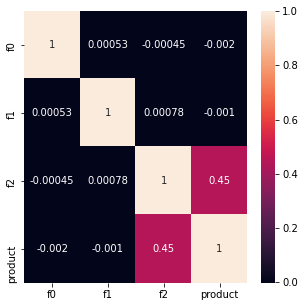

In [53]:
#посмотрим матрицу корреляций
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(ax=ax, data=data_2.corr(), annot = True)
plt.show()

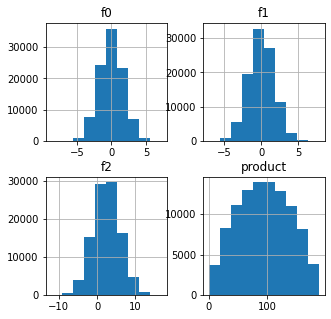

In [54]:
#получим гистограммы по всем столбцам
data_2.hist(figsize=(5, 5))
plt.show()

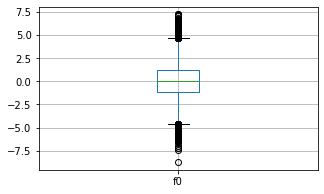

In [55]:
#проверим на выбросы
data_2.boxplot('f0', figsize=(5, 3))
plt.show()

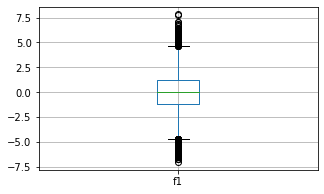

In [56]:
#проверим на выбросы
data_2.boxplot('f1', figsize=(5, 3))
plt.show()

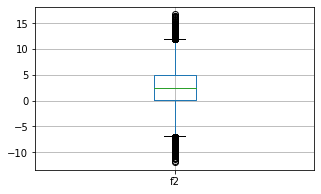

In [57]:
#проверим на выбросы
data_2.boxplot('f2', figsize=(5, 3))
plt.show()

In [58]:
#получим общую информацию о датасете
data_2.info()
print('Пропусков нет, ура')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Пропусков нет, ура


In [59]:
#удалим столбец с индексом, он будет мешать логистической регрессии
data_2.drop(columns=data_2.columns[0], axis= 1 , inplace= True )

In [60]:
#кодировать нам тут ничего не нужно, но стандартизировать и разделить данные - да
features_2 = data_2.drop(['product'],axis=1)
target_2 = data_2['product'] #целевой признак

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)



pd.options.mode.chained_assignment = None #чтобы не появлялось предупреждение SettingWithCopy

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_2[numeric])
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler.transform(features_valid_2[numeric])




### Выводы по подготовке данных

Данные содержатся в трех таблицах. Информация была экспортирована, прочитана, обработана для каждой таблицы. Данные были проверены на пропуски, выбросы, а также получено первое представление о распределении данных: получены гистограммы и матрицы корреляций. 

Далее данные были подготовлены к дальнейшему обучению модели линейной регрессии, они были разделены на тренировочную и валидационную выборки и стандартизированы. 

Для всех трех скважин было замечено, что в метриках f данные не всегда распределны нормально и сильно выбиваются. Далее это может способствовать увеличению среднеквадратической ошибки в исследуемом признаке. Также замечена сильная корреляция между метрикой f2 и целевым признаком. Это может говорить о наибольшем вкладе именно этой метрики. 

Данные полностью готовы к дальнейшей работе.



## Обучение и проверка модели

### Линейная регрессия

In [61]:
def regression(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train,target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке

    return mean_squared_error(target_valid, predictions_valid)**0.5, predictions_valid # посчитайте значение метрики RMSE на валидационной выборке
    

In [62]:
result_0, predictions_valid_0 = regression(features_train_0, target_train_0, features_valid_0, target_valid_0)
print("RMSE модели линейной регрессии на валидационной выборке скважины 0:", result_0)
print("Средний запас предсказанного сырья скважины 0:", predictions_valid_0.mean())
print()



result_1, predictions_valid_1 = regression(features_train_1, target_train_1, features_valid_1, target_valid_1)
print("RMSE модели линейной регрессии на валидационной выборке скважины 1:", result_1)
print("Средний запас предсказанного сырья скважины 1:", predictions_valid_1.mean())
print()

result_2, predictions_valid_2 = regression(features_train_2, target_train_2, features_valid_2, target_valid_2)
print("RMSE модели линейной регрессии на валидационной выборке скважины 2:", result_2)
print("Средний запас предсказанного сырья скважины 2:", predictions_valid_2.mean())
print()

RMSE модели линейной регрессии на валидационной выборке скважины 0: 37.5794217150813
Средний запас предсказанного сырья скважины 0: 92.59256778438035

RMSE модели линейной регрессии на валидационной выборке скважины 1: 0.893099286775617
Средний запас предсказанного сырья скважины 1: 68.728546895446

RMSE модели линейной регрессии на валидационной выборке скважины 2: 40.02970873393434
Средний запас предсказанного сырья скважины 2: 94.96504596800489



## Подготовка к расчёту прибыли

In [63]:
BUDGET = 10_000_000_000 #бюджет на разработку скважин в регионе
INCOME = 450_000 #доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
NECESSARY_VOLUME = BUDGET/INCOME/200
LOSSES = 0.025 #вероятность убытков должна быть меньше 2.5%

predictions_valid_0 = pd.DataFrame(data=predictions_valid_0).add_prefix("data")
predictions_valid_1 = pd.DataFrame(data=predictions_valid_1).add_prefix("data")
predictions_valid_2 = pd.DataFrame(data=predictions_valid_2).add_prefix("data")


print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {NECESSARY_VOLUME:.0f}')

Достаточный объём сырья для безубыточной разработки новой скважины: 111


### Промежуточные итоги

Для безубыточной разработки скважины необходимо 111 тысяч баррелей.


Средний запас предсказанного сырья скважины 0: 92

Средний запас предсказанного сырья скважины 1: 68

Средний запас предсказанного сырья скважины 2: 94

Вывод: Мы видим, что разброс данных в скважинах достаточно большой, что говорит о том, что среднее будет не очень показательно. Видно, что в нашем случае средние во всех трех скважинах меньше, чем достаточный объем для безубыточного случая добычи. Учитывая разброс, мы получим средние больше, чем этот достаточный объем. Это значит, что нам необходимо внимательно выбирать точки для скважин, чтобы выбрать максимально прибыльные

## Расчёт прибыли и рисков

In [64]:
#функция для расчета прибыли
def profit(target, predictions, count):

    predictions_max_index = predictions.sort_values(by = 'data0', ascending=False)
    product_target = target[predictions_max_index.index][:count].sum()

    return product_target*INCOME - BUDGET

In [65]:
#напишем функцию для подсчёта рисков, то есть доли отрицательной прибыли
def risk(values):
    count_all = 0
    count_minus = 0
    for i in range(len(values)):
        count_all += 1
        if values[i] <= 0:
            count_minus += 1
    return count_minus/count_all*100
            
        
    

## Оценка рисков и прибыли для каждого региона

In [66]:
state = np.random.RandomState(12345)

target_valid_0 = target_valid_0.reset_index(drop=True)

values_0 = []
for i in range(1000):
    target_subsample = target_valid_0.sample(n=500, replace=True, random_state=state)
    predictions_subsample = predictions_valid_0.iloc[target_subsample.index]

    values_0.append(profit(target_subsample,predictions_subsample, 200))



values_0 = pd.Series(values_0)
lower = values_0.quantile(0.025)
upper = values_0.quantile(0.975)


mean = values_0.mean()
print(f"Средняя прибыль: {mean:.0f}" ) 
print(f"2,5%-квантиль:  {lower:.0f}")
print(f"97,5%-квантиль:  {upper:.0f}")
print('Доля рисков для скважины 0: ', (values_0 < 0).mean() * 100, '%')




Средняя прибыль: 425938527
2,5%-квантиль:  -102090095
97,5%-квантиль:  947976353
Доля рисков для скважины 0:  6.0 %


In [67]:
target_valid_1 = target_valid_1.reset_index(drop=True)

values_1 = []
for i in range(1000):
    target_subsample = target_valid_1.sample(n=500, replace=True, random_state=state)
    predictions_subsample = predictions_valid_1.iloc[target_subsample.index]

    values_1.append(profit(target_subsample,predictions_subsample, 200))



values_1 = pd.Series(values_1)
lower = values_1.quantile(0.025)
upper = values_1.quantile(0.975)


mean = values_1.mean()
print(f"Средняя прибыль: {mean:.0f}" ) 
print(f"2,5%-квантиль:  {lower:.0f}")
print(f"97,5%-квантиль:  {upper:.0f}")
print('Доля рисков для скважины 1: ', (values_1 < 0).mean() * 100, '%')

Средняя прибыль: 518259494
2,5%-квантиль:  128123231
97,5%-квантиль:  953612982
Доля рисков для скважины 1:  0.3 %


In [68]:
target_valid_2 = target_valid_2.reset_index(drop=True)

values_2 = []
for i in range(1000):
    target_subsample = target_valid_2.sample(n=500, replace=True, random_state=state)
    predictions_subsample = predictions_valid_2.iloc[target_subsample.index]

    values_2.append(profit(target_subsample,predictions_subsample, 200))



values_2 = pd.Series(values_2)
lower = values_2.quantile(0.025)
upper = values_2.quantile(0.975)


mean = values_2.mean()
print(f"Средняя прибыль: {mean:.0f}" ) 
print(f"2,5%-квантиль:  {lower:.0f}")
print(f"97,5%-квантиль:  {upper:.0f}")
print('Доля рисков для скважины 2: ', (values_2 < 0).mean() * 100, '%')

Средняя прибыль: 420194005
2,5%-квантиль:  -115852609
97,5%-квантиль:  989629940
Доля рисков для скважины 2:  6.2 %


## Выводы по проекту


1) Загрузка и подготовка данных

Полученные исходные данные были для начала предобработаны, проверены на пропуски, выбросы, а также получено первое представление о распределении данных: получены гистограммы и матрицы корреляций.

Далее данные были подготовлены к дальнейшему обучению модели линейной регрессии, они были разделены на тренировочную и валидационную выборки и стандартизированы.

Для всех трех скважин было замечено, что в метриках f данные не всегда распределны нормально и сильно выбиваются. Далее это может способствовать увеличению среднеквадратической ошибки в исследуемом признаке. Также замечена сильная корреляция между метрикой f2 и целевым признаком. Это может говорить о наибольшем вкладе именно этой метрики.

2) Обучение и проверка модели

На данном этапе была обучена модель линейной регрессии. Для каждой скважины было получено стандартное отклонение и средний запас сырья в скважине

RMSE модели линейной регрессии на валидационной выборке скважины 0: 37.5794217150813
Средний запас предсказанного сырья скважины 0: 92.59256778438035

RMSE модели линейной регрессии на валидационной выборке скважины 1: 0.893099286775617
Средний запас предсказанного сырья скважины 1: 68.728546895446

RMSE модели линейной регрессии на валидационной выборке скважины 2: 40.02970873393434
Средний запас предсказанного сырья скважины 2: 94.96504596800489

3) Подготовка к расчёту прибыли

На данном этапе был рассчитан достаточный объём сырья для безубыточной разработки новой скважины: 111

Если сравнивать это значение с предыдущим пунктом, можно заметить, что средний запас по всей скважине меньше, чем достаточный объем, поэтому нужные скважины необходимо точнее выбирать.

4) Расчёт прибыли и рисков

На данном этапе были написаны функции для расчётв прибыли и рисков, которые применялись в следующем этапе.

5) Оценка рисков и прибыли для каждого региона

Здесь была применена техника Bootstrap с 1000 выборок, для нахождения распределения прибыли.Найдена среднюю прибыль для каждой скважины, 95%-й доверительный интервал и риск убытков. Таким образом для каждой скважины:

**Скважина 0:**

Средняя прибыль: 425938527

2,5%-квантиль:  -102090095

97,5%-квантиль:  947976353

Доля рисков для скважины 0:  6.0 %



**Скважины 1**

Средняя прибыль: 518259494

2,5%-квантиль:  128123231

97,5%-квантиль:  953612982

Доля рисков для скважины 1:  0.3 %

**Скважина 2**

Средняя прибыль: 420194005

2,5%-квантиль:  -115852609

97,5%-квантиль:  989629940

Доля рисков для скважины 2:  6.2 %


### **Рекомендации**

Наилучшей скважининой является скважина 1. Она имеет наименьший процент рисков - 0.3%. Остальные скважины имеют процент больший, чем 2.5%. Скважина 1 показывает среднее значение прибыли  518 259 494 рублей. 


